# 1 . Thư viện

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from vnstock.explorer.vci.financial import Finance
import pandas as pd


# 2. Function

# 3. Import data

In [7]:
#list cổ phiếu thuộc ngành sản xuất và midcap
list_stock=['ASM', 'CII', 'BWE', 'ANV', 'CTD', 'CRE', 'CMG', 'AAA', 'CTR']

#create một date-table rỗng
df_result=pd.DataFrame()
for stock in list_stock: #cho chạy stock chạy qua từng biến trong list_stock
    report = Finance(symbol=stock,period='quarter' )   # gán dữ liệu vào report ; Finance : một loại truy xuất từ các bài báo : symbol : tham số đại diện cho mã cổ phiếu, period : xác định kỳ của báo cáo tài chính là theo quý )
    data=report.balance_sheet(lang='vi')
    df_result=pd.concat([df_result,data])

df_result.to_csv('./data.csv',index=False)

In [8]:
data=pd.read_csv('./data.csv')

# 4. Processing data

# 5. Variable expansion

In [9]:
data.columns

Index(['CP', 'Năm', 'Kỳ', 'TÀI SẢN NGẮN HẠN (Tỷ đồng)',
       'Tiền và tương đương tiền (Tỷ đồng)',
       'Giá trị thuần đầu tư ngắn hạn (Tỷ đồng)',
       'Các khoản phải thu ngắn hạn (Tỷ đồng)', 'Hàng tồn kho ròng',
       'Tài sản lưu động khác', 'TÀI SẢN DÀI HẠN (Tỷ đồng)',
       'Phải thu về cho vay dài hạn (Tỷ đồng)', 'Tài sản cố định (Tỷ đồng)',
       'Giá trị ròng tài sản đầu tư', 'Đầu tư dài hạn (Tỷ đồng)',
       'Lợi thế thương mại', 'Tài sản dài hạn khác',
       'TỔNG CỘNG TÀI SẢN (Tỷ đồng)', 'NỢ PHẢI TRẢ (Tỷ đồng)',
       'Nợ ngắn hạn (Tỷ đồng)', 'Nợ dài hạn (Tỷ đồng)',
       'VỐN CHỦ SỞ HỮU (Tỷ đồng)', 'Vốn và các quỹ (Tỷ đồng)', 'Các quỹ khác',
       'Lãi chưa phân phối (Tỷ đồng)', 'Vốn Ngân sách nhà nước và quỹ khác',
       'LỢI ÍCH CỦA CỔ ĐÔNG THIỂU SỐ', 'TỔNG CỘNG NGUỒN VỐN (Tỷ đồng)',
       'Trả trước cho người bán ngắn hạn (Tỷ đồng)',
       'Phải thu về cho vay ngắn hạn (Tỷ đồng)',
       'Hàng tồn kho, ròng (Tỷ đồng)', 'Tài sản lưu động khác (Tỷ đồng)',


In [10]:
data.head()

,CP,Năm,Kỳ,TÀI SẢN NGẮN HẠN (Tỷ đồng),Tiền và tương đương tiền (Tỷ đồng),Giá trị thuần đầu tư ngắn hạn (Tỷ đồng),Các khoản phải thu ngắn hạn (Tỷ đồng),Hàng tồn kho ròng,Tài sản lưu động khác,TÀI SẢN DÀI HẠN (Tỷ đồng),...,Vốn góp của chủ sở hữu (Tỷ đồng),Vay và nợ thuê tài chính dài hạn (Tỷ đồng),Người mua trả tiền trước ngắn hạn (Tỷ đồng),Vay và nợ thuê tài chính ngắn hạn (Tỷ đồng),Lợi thế thương mại (Tỷ đồng),Trả trước dài hạn (Tỷ đồng),Tài sản dài hạn khác (Tỷ đồng),Phải thu dài hạn khác (Tỷ đồng),Phải thu dài hạn (Tỷ đồng),Trái phiếu chuyển đổi (Tỷ đồng)
0,ASM,2024,3,11722123395180,660403660947,1294633110421,5152481932450,4553874648376,60730042986,9080308475363,...,3701782500000,4476571304260,226262008913,6861319036422,3.641716e+11,628299308360,2.000000e+09,3.382323e+10,33837734163,NaN
1,ASM,2024,2,11481019688075,723619472881,1237963601506,5147764171630,4310154128162,61518313896,9151457740837,...,3365267520000,4310462628954,218047641221,6945704939712,3.725117e+11,635320604426,2.000000e+09,3.334922e+10,33363720763,NaN
2,ASM,2024,1,10999184770663,657496133753,1153509626518,4687404575326,4440092791223,60681643843,9295012589864,...,3365267520000,4359123189125,418094119169,6335976632560,3.895714e+11,645473724807,2.000000e+09,3.323135e+10,33245850763,NaN
3,ASM,2023,4,11097792363751,1365027739995,981956468827,4132243385406,4555774826135,62789943388,9217182495373,...,3365267520000,4579700947976,382783964460,6202057761377,4.066311e+11,656551695561,2.000000e+09,3.534935e+10,35363850763,NaN
4,ASM,2023,3,10011105362841,859294255163,1101796017811,4309319804698,3659916365273,80778919896,9402997612550,...,3365267520000,4260742040095,405399624886,5864504317714,4.236907e+11,635294635392,2.111111e+09,3.750308e+10,37517583329,NaN


# 6 Train model
> Cái cần quan tâm ở đây là:
* coef (Hệ số hồi quy) : Hệ số đứng trước biến
* P>|t| (Ý nghĩa thống kê của hệ số hồi quy) : Nếu nhỏ hơn 0.05 thì coef có ý nghĩa thống kê
* R-squared (Hệ số xác định của mô hình) : Thể hiện mức độ giải thích của các biến độc lập lên biến phục thuộc
* Prob (F-statistic) : Kiểm định mô hình (không nhớ rõ tên gọi). Nếu <0.05 thì mô hình có ý nghĩa thống kê

In [5]:
# Thêm cột hằng số cho hệ số chặn (Intercept)
X_with_const = sm.add_constant(X)

# Huấn luyện mô hình hồi quy tuyến tính
model = sm.OLS(y, X_with_const).fit()

# Kết quả tóm tắt
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4367.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           8.56e-49
Time:                        22:22:19   Log-Likelihood:                -66.142
No. Observations:                  50   AIC:                             136.3
Df Residuals:                      48   BIC:                             140.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0644      0.258      7.991      0.0

# 7. Cross Validation

In [6]:
# Dự đoán
X_new = np.linspace(0, 12, 10)  # Tạo giá trị mới để dự đoán
X_new_with_const = sm.add_constant(X_new)
y_predict= model.predict(X_new_with_const)
y_True=3*X_new+2

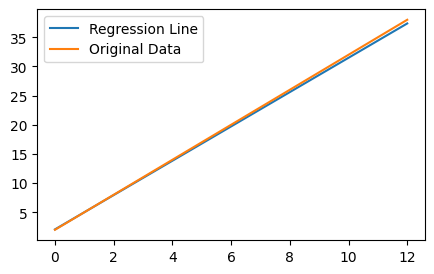

In [7]:
plt.figure(figsize=(5,3))
plt.plot(X_new,y_predict,label='Regression Line')
plt.plot(X_new,y_True,label='Original Data')
plt.legend()
plt.show()

# 8. Finnal model

In [ ]:
x= 2
y =3
